# Table of Contents

1. [Libraries](#0)
2. [Data](#2)
3. [Question 1](#4)
4. [Question 2](#6)
5. [Question 3](#8)
6. [Question 4](#10)
7. [Question 5](#12)
8. [Question 6](#14)


The City of Baltimore maintains a database of parking citations issued within the city. More information about the dataset can be found [here](https://data.baltimorecity.gov/Transportation/Parking-Citations/n4ma-fj3m). You can download the dataset as a CSV file [here](https://data.baltimorecity.gov/api/views/n4ma-fj3m/rows.csv). Unless stated otherwise, you should only consider citations written before January 1, 2019. A description of the data and the related possible filtering options and quesries can be found [here](https://dev.socrata.com/foundry/data.baltimorecity.gov/2ddy-2uzt).

### 1. Libraries <a id="0"></a>

In [2]:
# Check the python version
from platform import python_version
print(python_version())
# Importing the required libraries
import numpy as np
import pandas as pd
print(pd.__version__)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn import linear_model
from sklearn.metrics import r2_score
#pd.__version__

3.6.7
0.25.0


### 2. Data <a id="2"></a>

In [6]:
# API links to crime data 
datasize =  "https://data.baltimorecity.gov/resource/2ddy-2uzt.csv?$select=count(citation)"
df_datasize = pd.read_csv(datasize)
print('Number of data entries: ',df_datasize.iloc[0,0])
crime_url = "https://data.baltimorecity.gov/resource/2ddy-2uzt.csv?$limit={}".format(3385279) #df_datasize.iloc[0,0]
df_crime_tmp = pd.read_csv(crime_url,low_memory=False)
print('Size of dataset:',df_crime_tmp.shape[0])
print()
print(df_crime_tmp.columns)

Number of data entries:  3385279
Size of dataset: 3385279

Index(['citation', 'tag', 'expmm', 'expyy', 'state', 'make', 'location',
       'violcode', 'description', 'violfine', 'violdate', 'balance',
       'penaltydate', 'openfine', 'openpenalty', 'noticedate', 'importdate',
       'neighborhood', 'policedistrict', 'councildistrict', 'location_2_city',
       'location_2', 'location_2_address', 'location_2_zip',
       'location_2_state', ':@computed_region_5kre_ccpb',
       ':@computed_region_gwq4_fjxs', ':@computed_region_s6p5_2pgr'],
      dtype='object')


In [8]:
# Re-arranging data columns
df_crime = df_crime_tmp[['citation','tag','expmm','expyy','state','make',
                         'violcode','description','violfine',
                         'violdate','balance','openfine','openpenalty','noticedate',
                         'importdate','neighborhood', 'policedistrict',
                         'councildistrict','location_2_address','location_2_city',
                         'location_2_state','location_2_zip','location_2']]
# renaming some columns
df_crime.rename(columns={'location_2_address':'address','location_2_city':'city',\
                        'location_2_state':'state','location_2_zip':'zip_code',\
                        'location_2':'coordinates'},inplace=True)
print('The size of the data is: ',df_crime.shape)
df_crime.head()

The size of the data is:  (3385279, 23)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,citation,tag,expmm,expyy,state,make,violcode,description,violfine,violdate,...,noticedate,importdate,neighborhood,policedistrict,councildistrict,address,city,state,zip_code,coordinates
0,10607182,BYS4616,02,2.0,GA,LINCO,33,Mobile Speed Camera,40.0,NaN,...,NaN,2013-05-07T10:41:00.000,NaN,NaN,NaN,3200 BLOCK,OF THE ALAMEDA N B Baltimore,MD,NaN,POINT (-96.600842 33.671237)
1,10531036,3DVD23,01,13.0,MD,LINC,32,Fixed Speed Camera,40.0,2012-02-06T10:14:00.000,...,2012-04-17T20:00:00.000,2013-05-07T10:41:00.000,NaN,NaN,NaN,1200 BLOCK OF E NORTHERN PKWY,Baltimore,MD,NaN,POINT (-76.592772 39.366938)
2,10429819,32564M3,12,12.0,MD,LINC,32,Fixed Speed Camera,40.0,2012-01-30T18:02:00.000,...,2012-02-28T19:00:00.000,2013-05-07T10:41:00.000,NaN,NaN,NaN,2200 COLD SPRING LANE E,B Baltimore,MD,NaN,POINT (-76.5783 39.345251)
3,118950,9AZ2214,03,14.0,MD,CHRY,19,Exceeding 48 Hours,32.0,2014-04-23T15:30:00.000,...,2014-05-20T20:00:00.000,2015-12-09T04:02:00.000,NaN,NaN,NaN,1625 ABBTON ST,Baltimore,MD,NaN,NaN
4,10671956,2AN8294,04,12.0,MD,BUIC,32,Fixed Speed Camera,40.0,NaN,...,2012-04-17T20:00:00.000,2013-05-07T10:41:00.000,NaN,NaN,NaN,300 PATAPSCO AVE W,B Baltimore,MD,NaN,POINT (-76.617417 39.240237)


In [9]:
#---- Let's keep the data enteris up until January 1, 2019
# Fist let's see if we have null values for importdate and violation date
print('Number of null values in Violation Date column: ',df_crime['violdate'].isnull().sum())
print('Number of null values in Import Date column: ',df_crime['importdate'].isnull().sum())
print('Number of null values in Notice Date column: ',df_crime['noticedate'].isnull().sum())
# remove rows with null violation date values
df_crime = df_crime[~df_crime['violdate'].isnull()]
df_crime.reset_index(drop=True,inplace=True)

# Let's convert the date into proper format
df_crime['violdate']=df_crime['violdate'].astype('datetime64[ns]')
# Now, keep only the citations before Jan 1, 2019 and reset the index
date_input = "01Jan2019"
datevalue = datetime.strptime(date_input, "%d%b%Y")
print(datevalue)

df_crime=df_crime[df_crime['violdate']<datevalue]
df_crime.sort_values(by='violdate',ascending=False,inplace=True)
df_crime.reset_index(drop=True,inplace=True)
df_crime.head(10)

Number of null values in Violation Date column:  4530
Number of null values in Import Date column:  0
Number of null values in Notice Date column:  2540477
2019-01-01 00:00:00


,citation,tag,expmm,expyy,state,make,violcode,description,violfine,violdate,...,noticedate,importdate,neighborhood,policedistrict,councildistrict,address,city,state,zip_code,coordinates
0,52582930,20253HT,07,20.0,MD,TOYT,31,Right on Red,75.0,2018-12-31 23:57:00,...,NaN,2019-01-12T04:57:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,52582088,3CW8412,06,20.0,MD,TOYT,30,Red Light Violation,75.0,2018-12-31 23:54:00,...,NaN,2019-01-12T04:57:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,52582476,9BF7042,01,20.0,MD,MAZD,30,Red Light Violation,75.0,2018-12-31 23:49:00,...,NaN,2019-01-12T04:57:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,52582047,3DL3011,10,19.0,MD,HOND,31,Right on Red,75.0,2018-12-31 23:47:00,...,NaN,2019-01-12T04:57:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,52583102,VCK2479,00,0.0,VA,HOND,30,Red Light Violation,75.0,2018-12-31 23:45:00,...,NaN,2019-01-12T04:57:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,52582252,T743485,01,19.0,MD,MERZ,30,Red Light Violation,75.0,2018-12-31 23:45:00,...,NaN,2019-01-12T04:57:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,52581957,7BT3734,02,19.0,MD,MERZ,31,Right on Red,75.0,2018-12-31 23:42:00,...,NaN,2019-01-12T04:57:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,52582690,KFP9439,00,0.0,PA,HONDA,30,Red Light Violation,75.0,2018-12-31 23:41:00,...,NaN,2019-01-12T04:57:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,52582732,4AJ8198,01,19.0,MD,BUIC,30,Red Light Violation,75.0,2018-12-31 23:41:00,...,NaN,2019-01-12T04:57:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,52582922,9DN3401,12,20.0,MD,HOND,31,Right on Red,75.0,2018-12-31 23:41:00,...,NaN,2019-01-12T04:57:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Question 1: <a id="4"></a>
For all citations, what is the mean violation fine?

In [10]:
print('Number of null values in Violation Fine column: ',df_crime['violfine'].isnull().sum())
violfine_mean = df_crime['violfine'].mean()
print('The value for mean violation fine is %.10f' %violfine_mean)

Number of null values in Violation Fine column:  0
The value for mean violation fine is 49.1633474916


### Question 2: <a id="6"></a>
Looking only at vehicles that have open penalty fees, what dollar amount is the 81st percentile of that group?

81st percentile of non-zero open penalties: 480.0000000000
The maximum value is 3120.0000000000
The minimum value is 1.0000000000


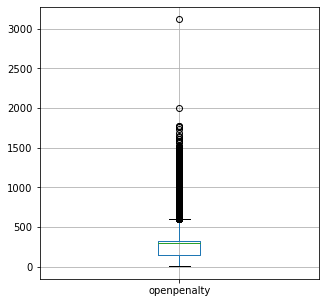

In [14]:
df_q2=df_crime[df_crime['openpenalty']!=0.0]
print('81st percentile of non-zero open penalties: %.10f' %df_q2['openpenalty'].quantile(0.81)) # 81st percentile
print('The maximum value is %.10f' %df_q2['openpenalty'].max()) # Max value
print('The minimum value is %.10f' %df_q2['openpenalty'].min()) # Max value
plt.figure(figsize=(5,5))
df_q2.boxplot(column=['openpenalty'])
plt.show()

### Question 3: <a id="8"></a>
Find all citations where the police district has been given. Next, determine which district has the highest mean violation fine. What is that mean violation fine? Keep in mind that Baltimore is divided into nine police districts, so clean the data accordingly. 

In [15]:
# First, let's see how many of enteries are missing in the police district data
print('Number of null values in Police District column: ',df_crime['policedistrict'].isnull().sum())

# Since we have no way of knowing the missing districts for violations, we will remove that part ofthe data
df_q3 = df_crime[~df_crime['policedistrict'].isnull()]
df_q3.reset_index(drop=True,inplace=True)

# Now, let's see how many districts we have
# First we make sure that they are written in the same foramt (let's go with title format)
df_q3['policedistrict'] = df_q3['policedistrict'].astype('str').str.title()
print('There are {} poilce district and they are as follows {}'.format(len(df_q3['policedistrict'].unique()),df_q3['policedistrict'].unique()))

# There seems to be a wrong entry as a typo which is 'Notheastern' and it should be 'Northeastern'
# So let's change it and correct the typo
df_q3['policedistrict']=df_q3['policedistrict'].str.replace('Notheastern','Northeastern')
# let's check again
print('There are {} poilce district and they are as follows {}'.format(len(df_q3['policedistrict'].unique()),df_q3['policedistrict'].unique()))


Number of null values in Police District column:  2520154


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


There are 10 poilce district and they are as follows ['Southeastern' 'Northern' 'Southern' 'Western' 'Notheastern'
 'Southwestern' 'Central' 'Eastern' 'Northwestern' 'Northeastern']
There are 9 poilce district and they are as follows ['Southeastern' 'Northern' 'Southern' 'Western' 'Northeastern'
 'Southwestern' 'Central' 'Eastern' 'Northwestern']


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [16]:
# Now, let's group the data based on districts
tmpvalue=df_q3.groupby('policedistrict')['violfine'].mean()
print('Police districts listed by their mean violation fine: ')
print(tmpvalue)
print()
df_tmp = pd.DataFrame(tmpvalue)
print('Police district with highest mean violation fine is %s and this value is %.10f' \
      %(df_tmp['violfine'].idxmax(),max(tmpvalue)))

Police districts listed by their mean violation fine: 
policedistrict
Central         44.607646
Eastern         50.597735
Northeastern    60.911736
Northern        47.774968
Northwestern    59.569724
Southeastern    48.011072
Southern        53.766353
Southwestern    58.415216
Western         53.328439
Name: violfine, dtype: float64

Police district with highest mean violation fine is Northeastern and this value is 60.9117357810


### Question 4: <a id="10"></a>
Find the ten vehicle makes that received the most citations during 2017. For those top ten, find all Japanese-made vehicles. What proportion of all citations were written for those vehicles? Note that the naming in Make is not consistent over the whole dataset, so you will need to clean the data before calculating your answer. Your answer should be expressed as a decimal number (i.e. 0.42, not 42). 

In [17]:
# limit the data to 2017
date_start = "01Jan2017"
date_end = "31Dec2017"
date_st = datetime.strptime(date_start, "%d%b%Y")
date_en = datetime.strptime(date_end, "%d%b%Y")
print('start date:',date_st)
print('end date:',date_en)

df_q4=df_crime.loc[(df_crime['violdate']>=date_st) & (df_crime['violdate']<=date_en)]
df_q4.sort_values(by='violdate',ascending=False,inplace=True)
df_q4.reset_index(drop=True,inplace=True)
df_q4.head(10)

start date: 2017-01-01 00:00:00
end date: 2017-12-31 00:00:00


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,citation,tag,expmm,expyy,state,make,violcode,description,violfine,violdate,...,noticedate,importdate,neighborhood,policedistrict,councildistrict,address,city,state,zip_code,coordinates
0,50424820,2CR6197,10,18.0,MD,TOYT,30,Red Light Violation,75.0,2017-12-30 23:58:00,...,NaN,2018-01-13T04:02:00.000,NaN,NaN,NaN,N E Calvert St NB,Baltimore,MD,NaN,NaN
1,50423962,7CF8226,01,18.0,MD,TOYT,30,Red Light Violation,75.0,2017-12-30 23:52:00,...,NaN,2018-01-13T04:02:00.000,NaN,NaN,NaN,E N North AVE WB,Baltimore,MD,NaN,NaN
2,50423954,5DD7689,01,18.0,MD,TOYT,30,Red Light Violation,75.0,2017-12-30 23:50:00,...,NaN,2018-01-13T04:02:00.000,NaN,NaN,NaN,E Loch Raven Blvd SB,Baltimore,MD,NaN,NaN
3,50423947,4CK0610,07,18.0,MD,HOND,30,Red Light Violation,75.0,2017-12-30 23:49:00,...,NaN,2018-01-13T04:02:00.000,NaN,NaN,NaN,W Northern Pkwy WB,Baltimore,MD,NaN,NaN
4,50423939,3FWT18,04,18.0,MD,PONT,31,Right on Red,75.0,2017-12-30 23:44:00,...,NaN,2018-01-13T04:02:00.000,NaN,NaN,NaN,E Loch Raven Blvd SB,Baltimore,MD,NaN,NaN
5,50425405,6CW6215,03,19.0,MD,ACUR,30,Red Light Violation,75.0,2017-12-30 23:43:00,...,NaN,2018-01-13T04:02:00.000,NaN,NaN,NaN,N Pulaski Hwy EB,Baltimore,MD,NaN,NaN
6,50423913,46152CF,03,18.0,MD,LNDR,30,Red Light Violation,75.0,2017-12-30 23:42:00,...,NaN,2018-01-13T04:02:00.000,NaN,NaN,NaN,W Northern Pkwy WB,Baltimore,MD,NaN,NaN
7,50425397,1AA1424,06,19.0,MD,HOND,30,Red Light Violation,75.0,2017-12-30 23:42:00,...,NaN,2018-01-13T04:02:00.000,NaN,NaN,NaN,W Northern Pkwy WB,Baltimore,MD,NaN,NaN
8,50425389,7CA4725,08,19.0,MD,TOYT,30,Red Light Violation,75.0,2017-12-30 23:39:00,...,NaN,2018-01-13T04:02:00.000,NaN,NaN,NaN,N Pulaski Hwy EB,Baltimore,MD,NaN,NaN
9,50425371,1CH6747,04,18.0,MD,KIA,30,Red Light Violation,75.0,2017-12-30 23:30:00,...,NaN,2018-01-13T04:02:00.000,NaN,NaN,NaN,N Pulaski Hwy EB,Baltimore,MD,NaN,NaN


In [18]:
# First, let's see how many of enteries are missing in the make column
print('Number of null values in Make column: ',df_crime['make'].isnull().sum())
# Since we have no way of knowing the missing values for models, we will remove that part of the data
df_q4 = df_q4[~df_q4['make'].isnull()]
df_q4.reset_index(drop=True,inplace=True)
df_q4 = df_q4[['make','citation','violdate']]

# Now, let's see how many models do we have
df_q4['make'] = df_q4['make'].str.strip() # Getting rid of extra spaces in the beginning and ending of each model name
df_q4['make'] = df_q4['make'].astype('str').str.upper() # make them all upper case
# Now, I will try to merge the similar model names
carlist_search = ['AUD','BENT',    'BMW','BUI',  'C/S','CAD',     'CHE',      'CHR',     'COOP','DOD','DOG',\
                 'FERR',  'FIA',  'GEN',    'GMC','HON',  'HOMD','HND',    'HYU',   'HYD',    'INF',      'ISU',   'JAG',\
                 'JAQ',   'JE',  'KIA','LAN',       'LEX',  'LIN',   'MAC',  'MAS',     'MAZ',   'MER',\
                 'MIN','NIS',    'NI',   'POL',  'PONT',   'POR',    'ROLL',       'SCI',  'SUB',   'SUZ',   'TES',\
                 'TOY',   'TRA',   'TRUC', 'VOLV', 'VLV', 'VOLC', 'VOL', 'VOLKS','VOLW', 'VOLK',\
                 'VW','YAM', 'FAIT', 'HUM', 'MB', 'MONDA', 'ACU', 'ME', 'MIT']
carlist_replac = ['AUDI','BENTLEY','BMW','BUICK','C/S','CADILLAC','CHEVROLET','CHRYSLER','COOPER','DODGE','DODGE',\
                 'FERRARI','FIAT', 'GENESIS','GMC','HONDA','HONDA', 'HONDA','HYUNDAI','HYUNDAI','INFINITI','ISUZU', 'JAGUAR',\
                 'JAGUAR','JEEP','KIA','LAND ROVER','LEXUS','LINCOLN','MACK','MASERATI','MAZDA','MERCEDES',\
                 'MINI','NISSAN','NISSAN','POLAR','PONTIAC','PORSCHE','ROLLS-ROYCE','SCION','SUBARU','SUZUKI','TESLA',\
                 'TOYOTA','RACTOR','TRUCK','VOLVO','VOLVO','VOLVO','VOLVO','VOLKSWAGEN','VOLKSWAGEN','VOLKSWAGEN',\
                 'VOLKSWAGEN','YAMAHA', 'FIAT','HUMMER','MERCEDES', 'HONDA', 'ACURA', 'MERCEDES', 'MITSUBISHI']
for count in range(len(carlist_search)):
    print(carlist_search[count],carlist_replac[count])
    df_q4.loc[df_q4['make'].str.contains(carlist_search[count]), 'make'] = carlist_replac[count]

print()
print( 'There are %d models' %len(df_q4['make'].unique()) )

Number of null values in Make column:  2834
AUD AUDI
BENT BENTLEY
BMW BMW
BUI BUICK
C/S C/S
CAD CADILLAC
CHE CHEVROLET
CHR CHRYSLER
COOP COOPER
DOD DODGE
DOG DODGE
FERR FERRARI
FIA FIAT
GEN GENESIS
GMC GMC
HON HONDA
HOMD HONDA
HND HONDA
HYU HYUNDAI
HYD HYUNDAI
INF INFINITI
ISU ISUZU
JAG JAGUAR
JAQ JAGUAR
JE JEEP
KIA KIA
LAN LAND ROVER
LEX LEXUS
LIN LINCOLN
MAC MACK
MAS MASERATI
MAZ MAZDA
MER MERCEDES
MIN MINI
NIS NISSAN
NI NISSAN
POL POLAR
PONT PONTIAC
POR PORSCHE
ROLL ROLLS-ROYCE
SCI SCION
SUB SUBARU
SUZ SUZUKI
TES TESLA
TOY TOYOTA
TRA RACTOR
TRUC TRUCK
VOLV VOLVO
VLV VOLVO
VOLC VOLVO
VOL VOLVO
VOLKS VOLKSWAGEN
VOLW VOLKSWAGEN
VOLK VOLKSWAGEN
VW VOLKSWAGEN
YAM YAMAHA
FAIT FIAT
HUM HUMMER
MB MERCEDES
MONDA HONDA
ACU ACURA
ME MERCEDES
MIT MITSUBISHI

There are 379 models


In [19]:
df_q4_sub=pd.DataFrame( df_q4.groupby(['make'])['citation'].agg(['count']) )
df_q4_sub.sort_values(by='count',ascending=False,inplace=True)
df_q4_sub.reset_index(inplace=True)
print('Top ten car makers: ')
print(df_q4_sub.head(10))

# Among these top ten car makers, 4 of them are japanese, including HONDA, TOYOTA, NISSAN, and ACURA
# So let's add their corresponding citations
Cit_Japanese = df_q4_sub.iloc[0,1]+df_q4_sub.iloc[1,1]+df_q4_sub.iloc[2,1]+df_q4_sub.iloc[8,1]
Cit_totall = df_q4_sub['count'].sum()
print('Share of Japanese cars in citations: %.10f' %(Cit_Japanese/Cit_totall))

Top ten car makers: 
        make  count
0      HONDA  70499
1     TOYOTA  68612
2     NISSAN  59594
3       FORD  56715
4  CHEVROLET  49469
5    HYUNDAI  28075
6      DODGE  21285
7      VOLVO  19817
8      ACURA  17343
9       JEEP  17003
Share of Japanese cars in citations: 0.3906432791


### Question 5: <a id="12"></a>
First, find the total number of citations given in each year between 2004 and 2014 (inclusive). Next, using linear regression, create a function that plots the total number of citations as a function of the year. If you were to plot a line using this function, what would be the slope of that line?

In [23]:
years = list(range(2004,2015))
value_totall_year =[]
for indx,year in enumerate(years):
    df_q5=pd.DataFrame()
    date_start = "01Jan"+str(year)
    date_end = "31Dec"+str(year)
    date_st = datetime.strptime(date_start, "%d%b%Y")
    date_en = datetime.strptime(date_end, "%d%b%Y")
    df_q5=df_crime.loc[(df_crime['violdate']>=date_st) & (df_crime['violdate']<=date_en)]
    value_tmp=df_q5[['violdate','citation']].groupby('violdate')['citation'].agg(['count'])
    value_totall_year.append(value_tmp.shape[0])
    #df_q5.sort_values(by='importdate',ascending=False,inplace=True)
    #df_q5.reset_index(drop=True,inplace=True)
    #df_q5.head(10)


Coefficients: 8829.3363636364
Intercept: -17692554.8454545476


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


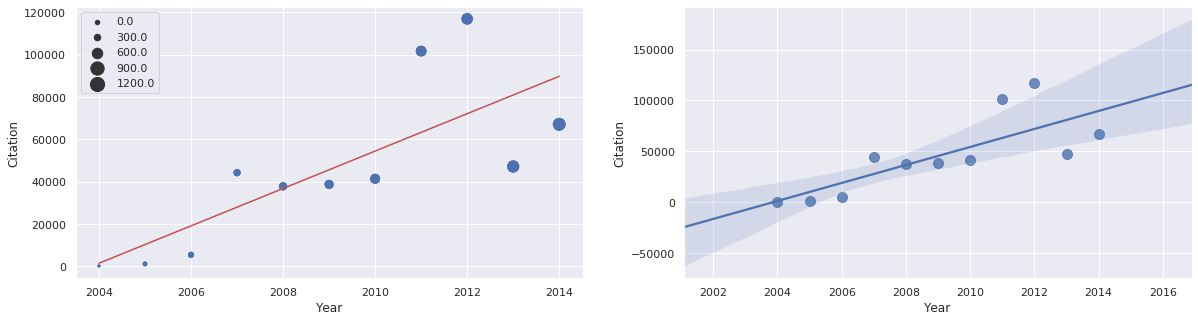

In [24]:
df_q5_sub = pd.DataFrame(value_totall_year,years)
df_q5_sub.reset_index(inplace=True)
df_q5_sub.columns = ['Year','Citation']

# Find the linear regression
regr = linear_model.LinearRegression()
train_x = np.array(df_q5_sub[['Year']])
train_y = np.array(df_q5_sub[['Citation']])
regr.fit (train_x, train_y)
# The coefficients
print ('Coefficients: %.10f' %regr.coef_)
print ('Intercept: %.10f' %regr.intercept_)

sns.set()
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 5)
sns.scatterplot(x='Year',y='Citation',data=df_q5_sub,size=np.linspace(200,1000,11),sizes=(20, 200),ax=ax1)
ax1.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
sns.regplot(x='Year',y='Citation',data=df_q5_sub,ax=ax2,scatter_kws={'s':100})
plt.show()

In [25]:
y_hat = regr.predict(train_x)
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_hat - train_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_hat - train_y) ** 2))
print("R2-score: %.2f" % r2_score(y_hat , train_y) )

Mean absolute error: 18271.40
Residual sum of squares (MSE): 535588658.04
R2-score: 0.31


### Question 6: <a id="14"></a>
To answer this last question, you will need to download another dataset: [The Baltimore Police Department Victim Based Crime Dataset](https://data.baltimorecity.gov/Public-Safety/BPD-Part-1-Victim-Based-Crime-Data/wsfq-mvij/). (CSV file is available [here](https://data.baltimorecity.gov/api/views/wsfq-mvij/rows.csv).) First, determine how many instances of auto theft ocurred in each police district during 2015. Next, determine the number of parking citations that were issued in each police district during the same year. Finally, determine the ratio of auto thefts to parking citations for each district. Out of the nine police districts, what was the highest ratio?

In [26]:
# API links to the data 
# following the example for this API at https://dev.socrata.com/blog/2016/02/02/plotly-pandas.html,
# we extract the data only for 2015
datasize =  "https://data.baltimorecity.gov/resource/wsfq-mvij.csv?\
&$where=crimedate%20between%20%272015-01-01T00:00:00%27%20and%20%272015-12-31T00:00:00%27&$select=count(crimedate)"
df_datasize = pd.read_csv(datasize)
print('Number of data entries: ',df_datasize.iloc[0,0])
# Now let's import the data
BPD_url = "https://data.baltimorecity.gov/resource/wsfq-mvij.csv?\
$limit={}&$where=crimedate%20between%20%272015-01-01T00:00:00%27%20\
and%20%272015-12-31T00:00:00%27".format(df_datasize.iloc[0,0])
df_BPD_tmp = pd.read_csv(BPD_url)
print('Size of dataset:',df_BPD_tmp.shape[0])
print()
print(df_BPD_tmp.columns)


Number of data entries:  48193
Size of dataset: 48193

Index(['crimedate', 'crimetime', 'crimecode', 'location', 'description',
       'inside_outside', 'weapon', 'post', 'district', 'neighborhood',
       'longitude', 'latitude', 'location_1', 'premise', 'vri_name1',
       'total_incidents'],
      dtype='object')


In [31]:
# Let's take a look at the data type for each column in dataframe
df_BPD_tmp.dtypes

crimedate           object
crimetime           object
crimecode           object
location            object
description         object
inside_outside      object
weapon              object
post               float64
district            object
neighborhood        object
longitude          float64
latitude           float64
location_1         float64
premise             object
vri_name1           object
total_incidents      int64
dtype: object

In [30]:
df_BPD_tmp.head(5)

,crimedate,crimetime,crimecode,location,description,inside_outside,weapon,post,district,neighborhood,longitude,latitude,location_1,premise,vri_name1,total_incidents
0,2015-01-01T00:00:00.000,11:30:00,6A,2000 W NORTH AVE,LARCENY,I,NaN,741.0,WESTERN,MONDAWMIN,-76.651086,39.309418,NaN,OTHER - INSIDE,Western,1
1,2015-01-01T00:00:00.000,10:00:00,5D,3900 WABASH AV,BURGLARY,I,NaN,643.0,NORTHWEST,EAST ARLINGTON,-76.665673,39.329142,NaN,GARAGE ON PRIV. PROP,NaN,1
2,2015-01-01T00:00:00.000,16:00:00,6D,700 W HAMBURG ST,LARCENY FROM AUTO,O,NaN,932.0,SOUTHERN,WASHINGTON VILLAGE,-76.627552,39.280757,NaN,STREET,NaN,1
3,2015-01-01T00:00:00.000,22:00:00,6D,100 N MILTON AVE,LARCENY FROM AUTO,NaN,NaN,222.0,SOUTHEAST,BALTIMORE-LINWOOD,-76.581944,39.293775,NaN,NaN,NaN,1
4,2015-01-01T00:00:00.000,22:15:00,4B,3000 FALLSTAFF MN CT,AGG. ASSAULT,I,KNIFE,632.0,NORTHWEST,CROSS COUNTRY,-76.694343,39.371553,NaN,ROW/TOWNHOUSE-OCC,NaN,1


In [33]:
# It seems like crimedate column is not in the right format and it is a string. Let's fix that and create a new column
df_BPD_tmp['crimedate'] = df_BPD_tmp['crimedate'].astype('datetime64[ns]')
df_BPD_tmp['date'] = pd.to_datetime(df_BPD_tmp['crimedate'].apply(str)+' '+df_BPD_tmp['crimetime'])

# Let's also keep only the information we need for this question
df_BPD=pd.DataFrame()
df_BPD[['Date','Description','District','Total_Incidents']] = df_BPD_tmp[['date','description','district','total_incidents']]

In [34]:
# Let's see how many district do we have
print('Number of null values in district column: ',df_BPD['District'].isnull().sum())
print('\nWe have {} districts which are: {} '.format(df_BPD['District'].unique().shape[0],df_BPD['District'].unique()) )
# There are some crimes reported that are associated with unkown district. Let's remove them from the data
df_BPD=df_BPD[df_BPD['District']!='UNKNOWN']
print('\nNow, we have {} districts which are: {} '.format(df_BPD['District'].unique().shape[0],df_BPD['District'].unique()) )

Number of null values in district column:  0

We have 10 districts which are: ['WESTERN' 'NORTHWEST' 'SOUTHERN' 'SOUTHEAST' 'NORTHERN' 'EASTERN'
 'CENTRAL' 'NORTHEAST' 'SOUTHWEST' 'UNKNOWN'] 

Now, we have 9 districts which are: ['WESTERN' 'NORTHWEST' 'SOUTHERN' 'SOUTHEAST' 'NORTHERN' 'EASTERN'
 'CENTRAL' 'NORTHEAST' 'SOUTHWEST'] 


In [35]:
df_q61=pd.DataFrame(df_BPD.groupby(['Description','District'])['Total_Incidents'].count())
df_q61.reset_index(inplace=True)
df_q61=df_q61[df_q61['Description']=='AUTO THEFT']
df_q61 = df_q61[['District','Total_Incidents']]
df_q61.sort_values(by='Total_Incidents',ascending=False,inplace=True)
df_q61.reset_index(drop=True,inplace=True)
print('Number of Auto Theft occured in each district: ')
print(df_q61)

Number of Auto Theft occured in each district: 
    District  Total_Incidents
0  NORTHEAST              821
1  NORTHWEST              567
2  SOUTHWEST              557
3    WESTERN              542
4   NORTHERN              498
5  SOUTHEAST              494
6   SOUTHERN              453
7    EASTERN              336
8    CENTRAL              294


In [36]:
# For the second part of the question, fist let's get the parking citation data for 2015
# limit the data to 2015
date_start = "01Jan2015"
date_end = "31Dec2015"
date_st = datetime.strptime(date_start, "%d%b%Y")
date_en = datetime.strptime(date_end, "%d%b%Y")
print('start date:',date_st)
print('end date:',date_en)

df_q62=df_crime.loc[(df_crime['violdate']>=date_st) & (df_crime['violdate']<=date_en)]
df_q62.sort_values(by='violdate',ascending=False,inplace=True)
df_q62.reset_index(drop=True,inplace=True)

start date: 2015-01-01 00:00:00
end date: 2015-12-31 00:00:00


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [37]:
#--- let's check the number of district in parking citation data
# First, let's see how many of enteries are missing in the police district data
print('Number of null values in Police District column: ',df_q62['policedistrict'].isnull().sum())
# Since we have no way of knowing the missing districts for violations, we will remove that part of the data
df_q62 = df_q62[~df_q62['policedistrict'].isnull()]
df_q62.reset_index(drop=True,inplace=True)
# Now, let's see how many districts do we have
# First, we make sure that they are written in the same foramt (let's go with title format)
df_q62['policedistrict'] = df_q62['policedistrict'].astype('str').str.title()
print('There are {} poilce district and they are as follows {}'.format(len(df_q62['policedistrict'].unique()),df_q62['policedistrict'].unique()))
# There seems to be a wrong entry as a typo which is 'Notheastern' and it should be 'Northeastern'
# So let's change it and correct the typo
df_q62['policedistrict']=df_q62['policedistrict'].str.replace('Notheastern','Northeastern')
# let's check again
print('There are {} poilce district and they are as follows {}'.format(len(df_q62['policedistrict'].unique()),df_q62['policedistrict'].unique()))


Number of null values in Police District column:  287853
There are 10 poilce district and they are as follows ['Central' 'Notheastern' 'Southeastern' 'Eastern' 'Northern' 'Southern'
 'Western' 'Southwestern' 'Northwestern' 'Northeastern']
There are 9 poilce district and they are as follows ['Central' 'Northeastern' 'Southeastern' 'Eastern' 'Northern' 'Southern'
 'Western' 'Southwestern' 'Northwestern']


In [39]:
# Now, let's keep the part of the data that we need and group it based on districts
df_q62n = pd.DataFrame()
df_q62n[['citation','policedistrict']] = df_q62[['citation','policedistrict']]
df_q62f=pd.DataFrame(df_q62n.groupby(['policedistrict'])['citation'].count())
df_q62f.reset_index(inplace=True)
df_q62f.columns=['District','Citations']
df_q62f.sort_values(by='District',ascending=True,inplace=True)
df_q62f.reset_index(drop=True,inplace=True)
print(df_q62f)

       District  Citations
0       Central      11804
1       Eastern       3110
2  Northeastern       4082
3      Northern       9557
4  Northwestern       1726
5  Southeastern      14911
6      Southern      12391
7  Southwestern       2578
8       Western       2475


In [40]:
# Let's re-arrange the data for parking citations in ascending order for district names so it is similar to data for crime
df_q61.sort_values(by='District',ascending=True,inplace=True)
df_q61.reset_index(drop=True,inplace=True)
print(df_q61)

    District  Total_Incidents
0    CENTRAL              294
1    EASTERN              336
2  NORTHEAST              821
3   NORTHERN              498
4  NORTHWEST              567
5  SOUTHEAST              494
6   SOUTHERN              453
7  SOUTHWEST              557
8    WESTERN              542


In [41]:
# Now, let's merge two data frames on index number
df_q6 = df_q62f.merge(df_q61, how='outer', left_index=True, right_index=True)
df_q6=df_q6[['District_y','District_x','Citations','Total_Incidents']]
df_q6.drop(columns=['District_x'],inplace=True)
df_q6.columns=['District','Citations','Total_Incidents']
df_q6['Ratio'] = df_q6['Total_Incidents']/df_q6['Citations']
df_q6.sort_values(by='Ratio',ascending=False,inplace=True)
df_q6.reset_index(drop=True,inplace=True)
print('The highest ratio of auto thefts to parking citations is %.10f and it belongs to district %s'\
      %(max(df_q6.Ratio),df_q6.iloc[df_q6['Ratio'].idxmax(),0]) )
print()
print(df_q6)

The highest ratio of auto thefts to parking citations is 0.3285052144 and it belongs to district NORTHWEST

    District  Citations  Total_Incidents     Ratio
0  NORTHWEST       1726              567  0.328505
1    WESTERN       2475              542  0.218990
2  SOUTHWEST       2578              557  0.216059
3  NORTHEAST       4082              821  0.201127
4    EASTERN       3110              336  0.108039
5   NORTHERN       9557              498  0.052108
6   SOUTHERN      12391              453  0.036559
7  SOUTHEAST      14911              494  0.033130
8    CENTRAL      11804              294  0.024907
